# Задача 1. 

## Описание проекта  и цель

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.

## Описание данных 

В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru. Данные о недвижимости собраны и загружены в базу данных.  

Столбцы:
 - url - ссылка на объявление 
 - date_app, date_update - даты подачи и обновления объявления
 - note - описание, текст объявления
 - apartment_type - тип недвижимости
 - neighborhood - район
 - street - улица
 - house - дом
 - floor - этаж
 - layout - планировка
 - total_area, living_area, kitchen_area - общая, жилая площади и площадь кухни
 - views - количество просмотров
 - price - целевой признак, цена

## План работы

1. Подготовка данных:
 - Открыть файлы и изучить их. 
 - Посмотреть какие данные можно использовать для обучения модели, произвести предобработку данных.
 - Добавить новые признаки, которые помогут в обучении модели (Feature Engineering).
2. Подготовка к обучению модели
 - Разбиение датафрейма на выборки и анализ данных
 - Проверка мультиколлинеарности признаков и корреляции с таргетом.
 - Отбор признаков (Feature Selection)
 - Выбор моделей для обучения (2-3 модели).
3. Подбор и обучение моделей:
 - Проверка метрики на тесте константной модели.
 - Подбор лучших гиперапараметров моделей на кросс-валидации.
 - Проверка лучшей модели на тестовой выборке.
 - Определить какие признаки модель посчитала самыми важными для прогноза.
4. Выводы - отчет.

## 1. Подготовка данных

In [1]:
# Импорт библиотек
import warnings
import re
import datetime
import json
import random

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sqlite3
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

In [2]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.2

### Откроем файл и изучим его

In [3]:
conn = sqlite3.connect('database.db')

In [4]:
df = pd.io.sql.read_sql('SELECT * FROM base', conn)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
0,http://citystar.ru/scard.asp?d=43&id=15909831,30.08.2023 15:22:27,02.09.2023 14:03:02,В продаже 4-х комнатная квартира. С хорошим ре...,Трехкомнатная,Орджоникидзевский,Труда,14,8/9,,80.0,53.0,9.0,5999,38
1,http://citystar.ru/scard.asp?d=43&id=15909830,30.08.2023 14:57:57,02.09.2023 14:02:56,Продается 4-х комнатная квартира нестандартной...,Четырехкомнатная,Орджоникидзевский,Труда,18,9/9,,79.0,52.7,8.2,6350,26
2,http://citystar.ru/scard.asp?d=43&id=15927949,02.09.2023 14:02:00,02.09.2023 14:02:21,Продам 3-х комнатную квартиру\r\nпремиум-класс...,Трехкомнатная,Орджоникидзевский,Ленина пр-т,129/2,6/9,,105.0,78.0,14.0,8700,5
3,http://citystar.ru/scard.asp?d=43&id=15927071,02.09.2023 8:11:48,02.09.2023 8:11:48,id:26867. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,Многокомнатная,,Калмыкова,14,8/9,,65.0,45.0,8.0,4800,9
4,http://citystar.ru/scard.asp?d=43&id=15927070,02.09.2023 8:11:47,02.09.2023 8:11:47,id:26185. \r\nП продаже отличная двухкомнатная...,Двухкомнатная,,Суворова,136/1,2/5,,44.3,30.0,6.0,2980,6


In [5]:
# Посмотрим на размеры файла
df.shape

(400, 15)

In [6]:
# Проверка на пропуски
df.isna().sum()

url               0
date_app          0
date_update       0
note              0
apartment_type    0
neighborhood      0
street            0
house             0
floor             0
layout            0
total_area        0
living_area       0
kitchen_area      0
price             0
views             0
dtype: int64

In [7]:
df.iloc[2]['layout']

''

Пропусков нет, но есть значения с пустыми строками.

In [8]:
# Проверка на дубликаты
df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated().sum()

3

In [9]:
# Посмотрим на дубликаты
df.loc[df.drop(['url', 'date_app', 'date_update', 'views'], axis = 1).duplicated()]

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views
350,http://citystar.ru/scard.asp?d=43&id=15173851,05.05.2023 10:39:56,05.05.2023 10:39:56,,Двухкомнатная,Правобережный,"Им. газеты ""Правда""",23,4/5,,46.1,29.0,6.0,2600,73
356,http://citystar.ru/scard.asp?d=43&id=15157805,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4253. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Двухкомнатная,правобережный,ул Помяловского,7,4/5,,43.5,27.0,6.0,2650,55
357,http://citystar.ru/scard.asp?d=43&id=15157804,03.05.2023 7:56:17,03.05.2023 7:56:17,id:4252. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕНИ...,Трехкомнатная,Орджоникидзевский,ул Репина,12,1/1,,55.0,39.0,6.0,0,45


In [10]:
# Удалим дубликаты
df = df.drop_duplicates(subset = df.columns[3:-1].to_list())
df.shape

(397, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 0 to 399
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   url             397 non-null    object 
 1   date_app        397 non-null    object 
 2   date_update     397 non-null    object 
 3   note            397 non-null    object 
 4   apartment_type  397 non-null    object 
 5   neighborhood    397 non-null    object 
 6   street          397 non-null    object 
 7   house           397 non-null    object 
 8   floor           397 non-null    object 
 9   layout          397 non-null    object 
 10  total_area      397 non-null    float64
 11  living_area     397 non-null    float64
 12  kitchen_area    397 non-null    float64
 13  price           397 non-null    int64  
 14  views           397 non-null    int64  
dtypes: float64(3), int64(2), object(10)
memory usage: 49.6+ KB


Видно, что у столбца floor тип данных указан object. Изменим на int64. 

Так же изменим тип данных у столбцов date_app, date_update - это даты.
У столбца house на int.

#### floor

In [12]:
df['total_floors'] = df['floor'].apply(lambda x: x.split('/')[1])
df['floor'] = df['floor'].apply(lambda x: x.split('/')[0])

In [13]:
df['total_floors'] = df['total_floors'].astype('int64')
df['floor'] = df['floor'].astype('int64')

#### date_app, date_update

In [14]:
# В столбцах с date_app и date_update оставим только дату, без времени и переведем в соответствующий формат
df['date_app'] = pd.to_datetime(df['date_app'].apply(lambda x: x.split()[0]), format='%d.%m.%Y')

In [15]:
df['date_update'] = pd.to_datetime(df['date_update'].apply(lambda x: x.split()[0]), format='%d.%m.%Y')

In [16]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_app'].min(), df['date_app'].max()

(Timestamp('2021-10-25 00:00:00'), Timestamp('2023-09-02 00:00:00'))

In [17]:
# Посмотрим на минимальное и максимальное значения столбца
df['date_update'].min(), df['date_update'].max()

(Timestamp('2023-04-01 00:00:00'), Timestamp('2023-09-02 00:00:00'))

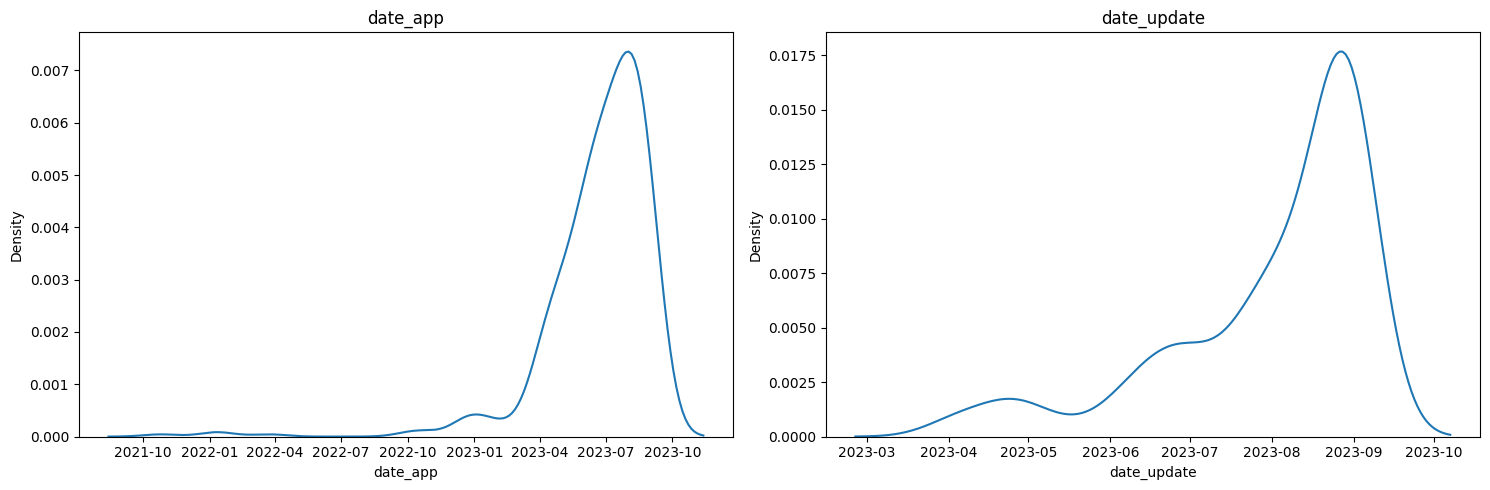

In [18]:
# Посмтроим график плотности в зависимости от дат 
features = ['date_app', 'date_update']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    sns.kdeplot(data=df, x = features[i], ax=axes[i])
    axes[i].set_title(f'{features[i]}')
plt.tight_layout()
plt.show()

Видно, что представлены объявления о продаже недвижимости за период с октября 2021 года по август 2023. Период обновления (редактирования) представлен с марта 2023 по август 2023г.

Ожидаемо, основная масса объявлений были опубликованы в 2023 году, в период с апреля по август и редактировалась большая часть из них в последний месяц. Т.е. нерелевантных объявлений нет.

#### note

In [19]:
cat_columns = ['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']
cat_columns

['url', 'note', 'apartment_type', 'neighborhood', 'street', 'layout']

In [20]:
# Приведем все строковые значения к нижнему регистру
df[cat_columns] = df[cat_columns].apply(lambda row: row.str.lower(), axis = 1)
df.head()

,url,date_app,date_update,note,apartment_type,neighborhood,street,house,floor,layout,total_area,living_area,kitchen_area,price,views,total_floors
0,http://citystar.ru/scard.asp?d=43&id=15909831,2023-08-30,2023-09-02,в продаже 4-х комнатная квартира. с хорошим ре...,трехкомнатная,орджоникидзевский,труда,14,8,,80.0,53.0,9.0,5999,38,9
1,http://citystar.ru/scard.asp?d=43&id=15909830,2023-08-30,2023-09-02,продается 4-х комнатная квартира нестандартной...,четырехкомнатная,орджоникидзевский,труда,18,9,,79.0,52.7,8.2,6350,26,9
2,http://citystar.ru/scard.asp?d=43&id=15927949,2023-09-02,2023-09-02,продам 3-х комнатную квартиру\r\nпремиум-класс...,трехкомнатная,орджоникидзевский,ленина пр-т,129/2,6,,105.0,78.0,14.0,8700,5,9
3,http://citystar.ru/scard.asp?d=43&id=15927071,2023-09-02,2023-09-02,id:26867. \r\nвнимание! эксклюзивное предложен...,многокомнатная,,калмыкова,14,8,,65.0,45.0,8.0,4800,9,9
4,http://citystar.ru/scard.asp?d=43&id=15927070,2023-09-02,2023-09-02,id:26185. \r\nп продаже отличная двухкомнатная...,двухкомнатная,,суворова,136/1,2,,44.3,30.0,6.0,2980,6,5


В данном столбце представлено описание продаваемой недвижимости.

In [21]:
df['note'].iloc[np.random.randint(len(df))]

'продажа квартир в жилом комплексе  орлёнок \r\n \r\nрасположен в одном из живописных мест башкортостана, с западного склона хребта крыктытау вдоль реки малый кизил, в 3 километрах от глц  абзаково . со всех сторон окружен смешанным лесом, с преобладанием хвойных пород. лето со средней температурой +28 градусов. действующая гостиница орлёнок.\r\n \r\nадрес: республика башкортостан, белорецкий район, п. абзаково, ул. ленина, д. 220\r\n \r\nподъезд до поселка и в нем асфальт. от магнитогорска до станции  ново-абзаково  время в пути 40 мин. уличное освещение, видеонаблюдение, охрана. сквер, с детской площадкой и местами для отдыха на территории посёлка. земли рекреационного назначения.\r\n \r\nв продаже однокомнатные квартиры приусадебного типа, площадью 35 м2. дом-дача на 7 квартир, на 20 сотках земли, с возможностью отделения для себя, по согласованию с соседями. предчистовая отделка, газовый котел, бойлерная, на один дом. электроразводка, радиаторы отопления, электросчётчик, двойные ст

Далее переведем этот столбец в векторный формат при помощи tf-idf

#### apartment_type

In [22]:
df['apartment_type'].unique()

array(['трехкомнатная', 'четырехкомнатная', 'многокомнатная',
       'двухкомнатная', 'однокомнатная', ''], dtype=object)

In [23]:
df['apartment_type'].value_counts()

apartment_type
двухкомнатная       141
трехкомнатная       132
однокомнатная        96
четырехкомнатная     17
многокомнатная        6
                      5
Name: count, dtype: int64

Данных нет только в пяти случаях.

#### neighborhood, street

In [24]:
df['neighborhood'].unique()

array(['орджоникидзевский', '', 'правобережный', 'ленинский',
       'орджоникидзевский (левый берег)', 'правобережный район',
       'ленинский (левый берег)'], dtype=object)

In [25]:
df.loc[df['neighborhood'] == 'правобережный район', 'street'].unique()

array(['ул имени газеты правда'], dtype=object)

In [26]:
df.loc[df['neighborhood'] == 'правобережный', 'street'].unique()

array(['ул суворова', 'грязнова', 'сталеваров', 'карла маркса',
       'завенягина', 'ленина пр-т', 'им. газеты "правда"',
       'ул. суворова 95 к.1', 'советская', 'суворова', 'советской армии',
       'ул. феодосия воронова', 'галиуллина', 'ул грязнова', 'мичурина',
       'советский переулок', 'ул. имени газеты правда',
       'советский переулок 12', 'ул помяловского', 'гагарина',
       'индустриальная'], dtype=object)

Видны опечатки в названии районов, например, правобережный и правобережный район - это один и тот же район.

In [27]:
# Избавимся от опечаток
df.loc[df['neighborhood'] == 'правобережный район', 'neighborhood'] = 'правобережный'

In [28]:
# Посмотрим как часто не указан район
len(df.loc[df['neighborhood'] == ''])

153

Район не указан почти в 40% случаев. Оценим ситуацию с улицами. Для этого названия улиц приведем к единому формату.

In [29]:
# Убираем цифры и лишние символы в названиях улиц
df['street'] = df['street'].apply(lambda x: x.replace('ул ', ''))
df['street'] = df['street'].apply(lambda x: x.replace('ул. ', ''))
df['street'] = df['street'].apply(lambda x: x.replace(' пр-т', ''))
df['street'] = df['street'].apply(lambda x: re.sub(r'[^а-яё\s]', '', x).strip())

In [30]:
df.groupby('street')['neighborhood'].agg('count').sort_values(ascending = False)[:10]

street
ленина            60
карла маркса      51
советская         18
зеленый лог       17
труда             15
летия магнитки    11
грязнова          10
курортная          8
московская         7
суворова           7
Name: neighborhood, dtype: int64

Чаще всего продаются квартиры на ул. Ленина, Маркса, Советсткой, Зеленый лог, труда. Возможно, это связано с тем, что проспект Ленина и проспект Карла Маркса - одни из самых протяженных в Магнитогорске.

In [31]:
# Определим наблюдения у которых не заполнено поле street
len(df.loc[df['street'] == ''])

6

In [32]:
df['street'].unique()

array(['труда', 'ленина', 'калмыкова', 'суворова', 'ленинградская',
       'сиреневый проезд', 'карла маркса', 'московская', 'ворошилова',
       'грязнова', 'тимирязева', 'западное шоссе', 'сталеваров',
       'тевосяна', 'санаторная', 'металлургов', 'им газеты правда',
       'уральская', 'прпушкина', 'жукова', 'герцена', 'летия магнитки',
       'строителей', 'советская', 'первомайская', 'панькова',
       'российская', 'разина', 'мичурина', 'завенягина', 'куйбышева',
       'коробова', 'октябрьская', 'галиуллина', 'центральная', 'горького',
       'лесная', 'чайковского', 'новая', 'писарева', 'зеленый лог',
       'салтыковащедрина', 'суворова  к', 'бориса ручьева', 'менделеева',
       'имени газеты правда', 'трамвайная', 'пекинская', 'лесопарковая',
       'чапаева', 'советской армии', 'школьная', 'курортная', 'бурденко',
       'набережная', 'феодосия воронова', 'вокзальная', 'чекалина',
       'доменщиков', 'лермонтова', 'фадеева', '', 'тарасенко',
       'черемушки', 'молодежн

#### layout

In [33]:
df['layout'].unique()

array(['', 'старой планировки', 'брежневка', 'сталинский вариант',
       'нестандартная', 'ленинградский проект', 'хрущевка', 'улучшенная',
       'малосемейка', 'полусмежная', 'раздельная', 'свердловский вариант',
       'полустудия', 'гребенка', 'распашонка', 'студия'], dtype=object)

In [34]:
df['layout'].value_counts()[:10]

layout
                        287
брежневка                22
нестандартная            19
улучшенная               19
старой планировки        16
раздельная               10
хрущевка                  5
сталинский вариант        4
ленинградский проект      3
свердловский вариант      3
Name: count, dtype: int64

Данный признак скорее всего не будет информативным так как почти 3/4 значений не заполнено. Остальные значения встречаются крайне редко.

Так же удалим url - он тоже не информативен

In [35]:
df = df.drop('layout', axis = 1)
df = df.drop('url', axis = 1)

In [36]:
df.drop(['date_app', 'date_update'], axis = 1).describe()

,floor,total_area,living_area,kitchen_area,price,views,total_floors
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,3.727960,57.065315,32.421511,8.686322,3608.176322,57.551637,6.251889
std,2.627852,28.714942,18.106273,3.701445,1629.786433,69.528248,3.570647
min,1.000000,14.100000,0.000000,0.000000,0.000000,5.000000,1.000000
25%,2.000000,42.600000,19.000000,6.000000,2600.000000,24.000000,4.000000
50%,3.000000,52.600000,31.000000,8.000000,3400.000000,42.000000,5.000000
75%,5.000000,65.300000,43.900000,10.000000,4400.000000,70.000000,9.000000
max,14.000000,318.000000,150.000000,35.500000,12750.000000,1022.000000,17.000000


В данным видны аномалии - у которых стоимость равна 0, такие наблюденя лучше исключить из датасета. 

In [37]:
df = df.loc[df['price'] != 0]

In [38]:
len(df.loc[df['living_area'] == 0])

36

In [39]:
len(df.loc[df['kitchen_area'] == 0])

7

In [40]:
df.loc[df['kitchen_area'] == 0, 'note']

139    старт продаж !!!br    новая квартира студия на...
207    предлагаем вашему вниманию квартиру в новом жи...
221    представляем вашему вниманию уютную студию с р...
266    id:4836. \r\nв продаже уютная трёхкомнатная кв...
272    id:1182. \r\nпродается теплая полусмежная трех...
353    продам апартаменты на озере банное, в центре д...
397    id:2882. \r\n3-х квартира 9/9 этаж, рядом школ...
Name: note, dtype: object

Так же видно, что в 11 случаях не указана площадь кухни, а в 34 случаях не указана жилая площадь. Такие данные тоже лучше исключать из датасета, так как это ошибка или пропуск по сути. Но так как данных мало оставим эти строки.

#### house

In [41]:
len(df['house'].unique())

203

Данный признак слишком вариативен, его невозможно перевести в целочисленный так как есть дома указанные через слэш или дома с литерами, например 129/2 или 36А. Так же удалим этот столбец.

In [42]:
df = df.drop('house', axis = 1)

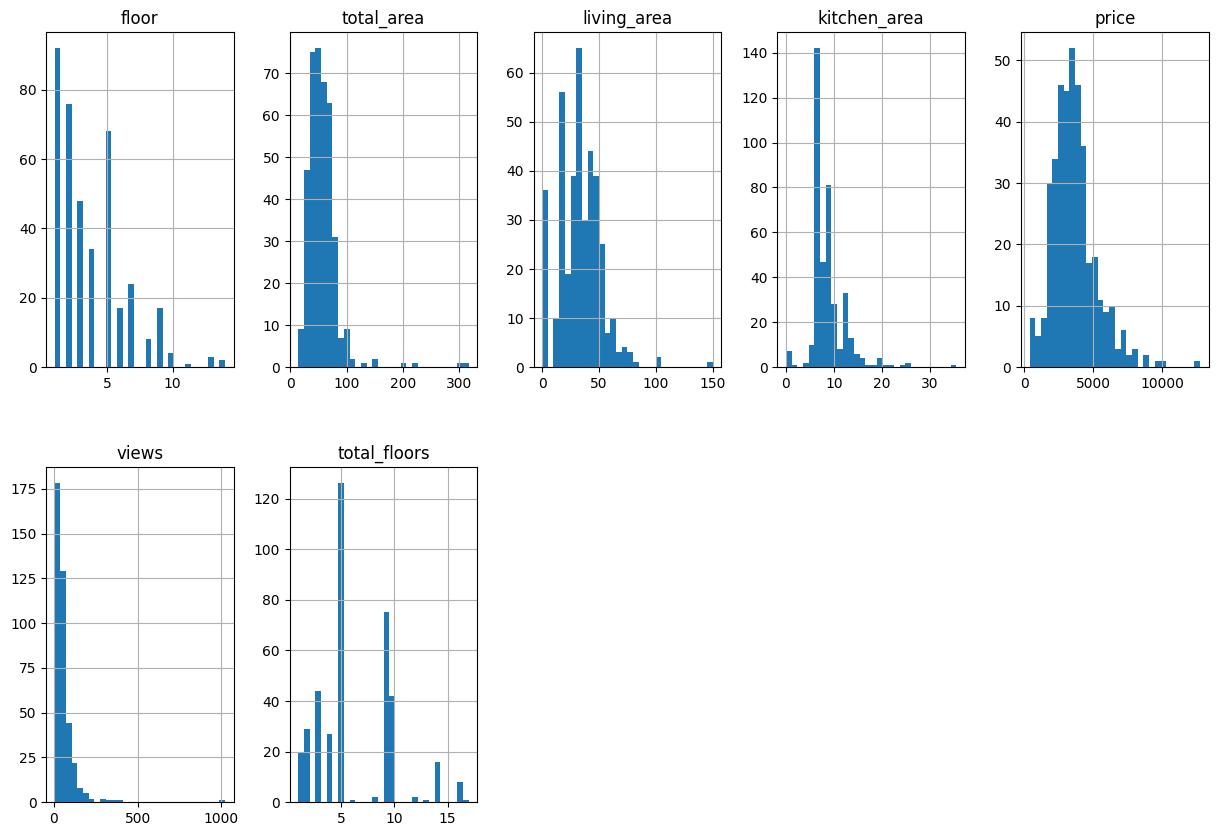

In [43]:
# 
df.drop(['date_app', 'date_update'], axis = 1).hist(figsize=(15, 10), layout=(-1, 5), bins = 30);

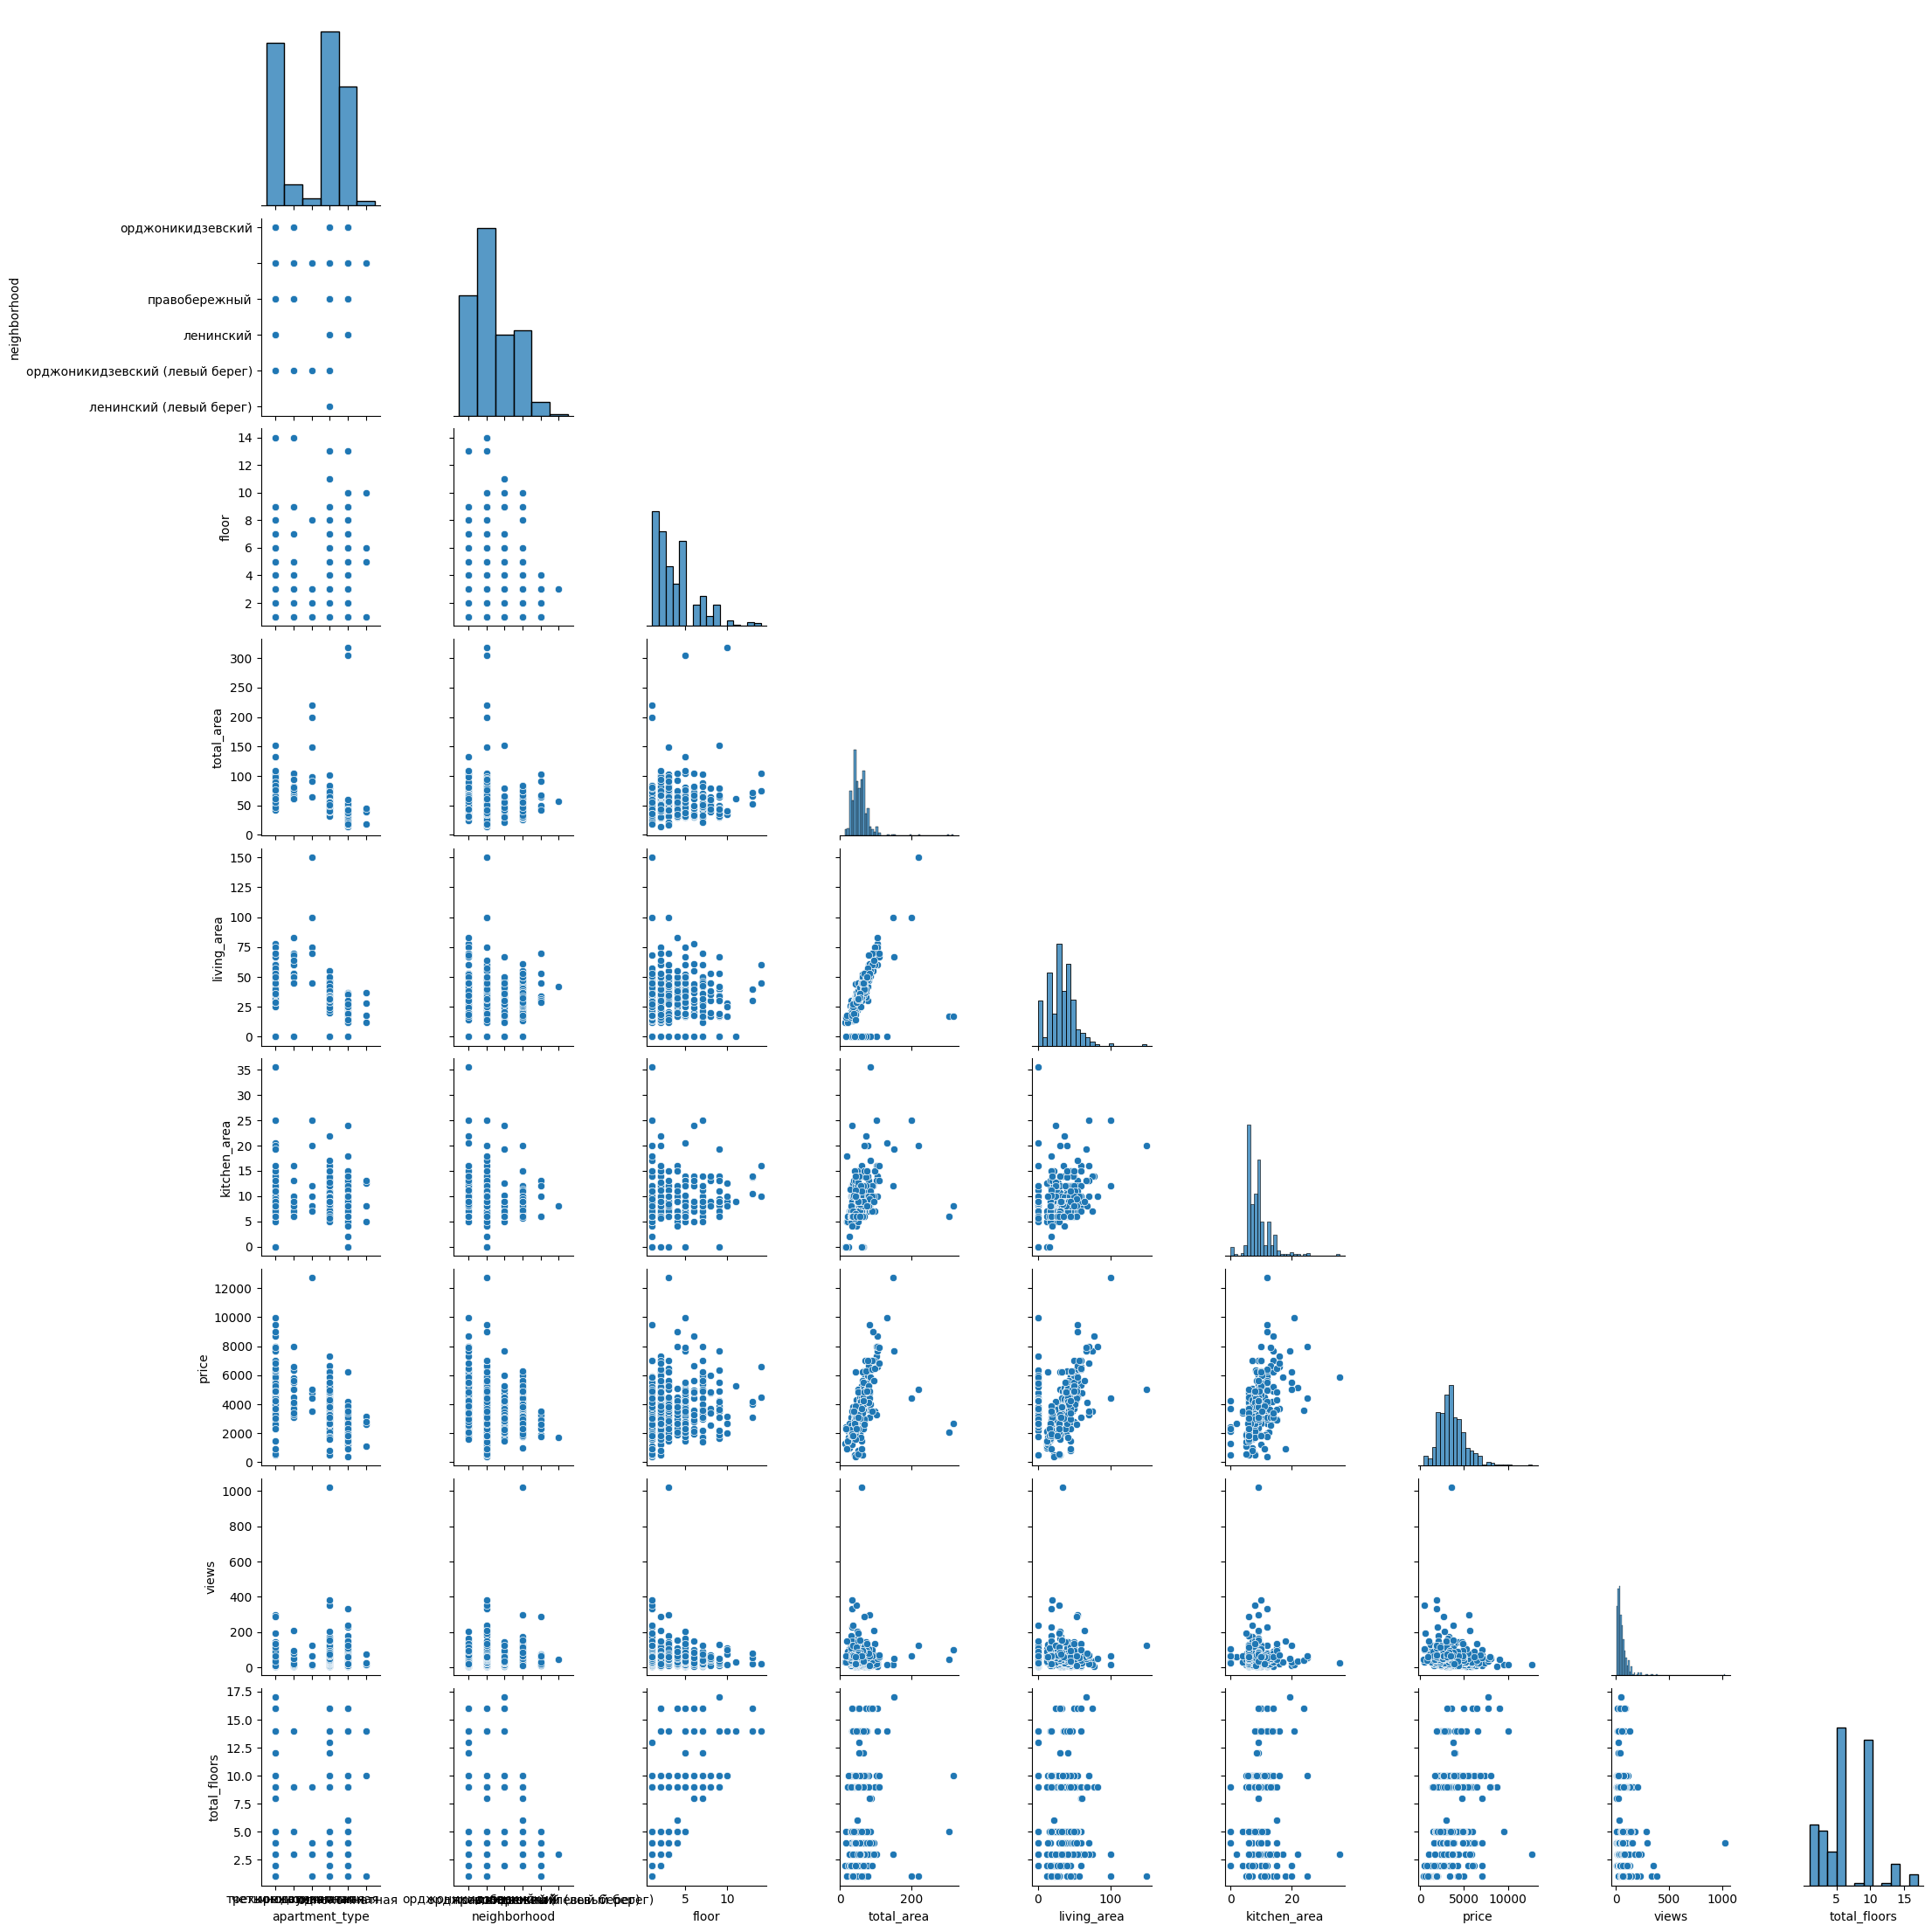

In [44]:
sns.pairplot(
    df,
    vars=['apartment_type',
       'neighborhood', 'floor', 'total_area',
       'living_area', 'kitchen_area', 'price', 'views', 'total_floors'],
    corner=True,
);

Как и ожидалось, видна положительная взаимосвязь между признаками с площадью и стоимостью.

### Добавим новые признаки

Разница между датой подачи и датой обновления объявления может помочь определить, как долго объявление находится в активном состоянии. Это может быть полезным признаком, поскольку более свежие объявления могут быть более актуальными и иметь более высокую цену.

In [45]:
# Возраст объявления
df['age'] = (datetime.datetime.today() - df['date_app']) / np.timedelta64 ( 1 , 'D')

<Axes: >

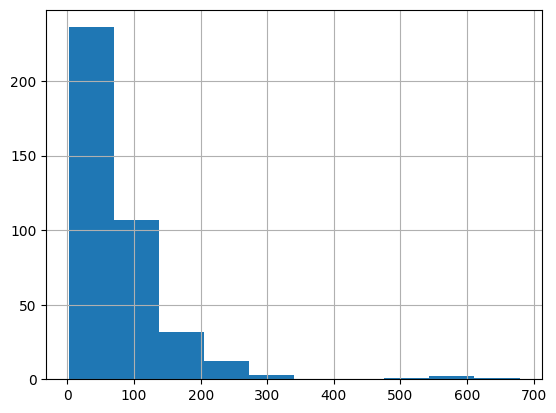

In [46]:
df['age'].hist()

Создадим признаки, которые представляют собой отношение между жилой площадью и общей площадью, а также отношение между площадью кухни и общей площадью. Эти признаки могут помочь учесть пропорции различных зон и их влияние на цену.

In [47]:
df['living/total'] = df['living_area']/df['total_area']
df['kitchen/living'] = df['living_area']/df['kitchen_area']

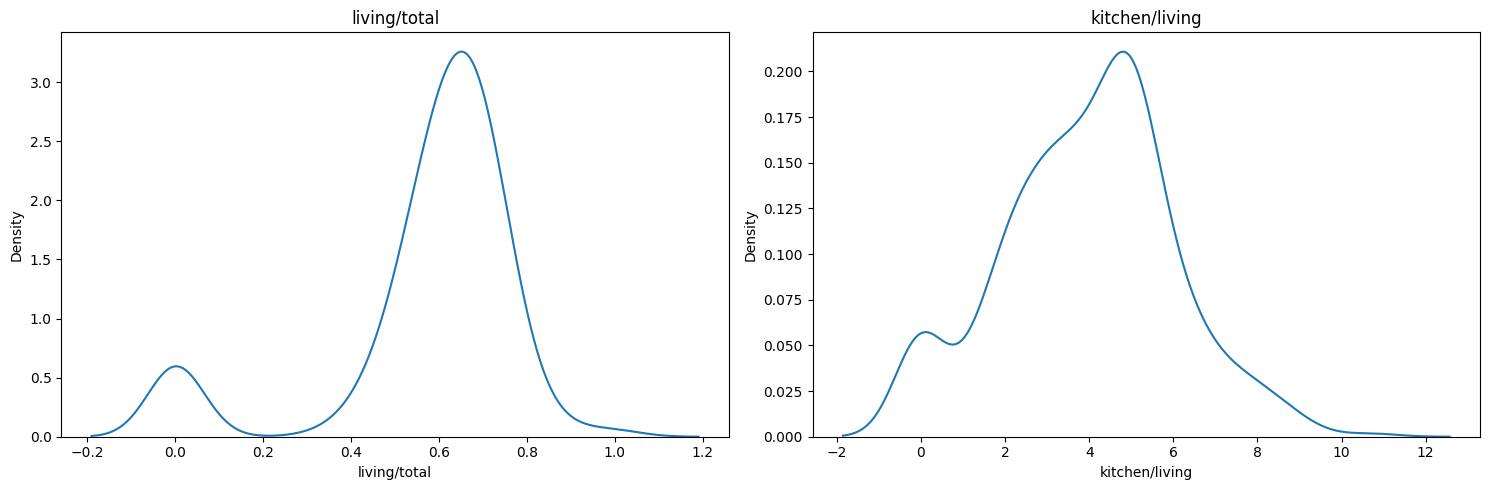

In [48]:
# 
features = ['living/total', 'kitchen/living']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    sns.kdeplot(data=df, x = features[i], ax=axes[i])
    axes[i].set_title(f'{features[i]}')
plt.tight_layout()
plt.show()

In [49]:
df.loc[df['kitchen/living'].isna()].head()

,date_app,date_update,note,apartment_type,neighborhood,street,floor,total_area,living_area,kitchen_area,price,views,total_floors,age,living/total,kitchen/living
221,2023-07-16,2023-09-01,представляем вашему вниманию уютную студию с р...,однокомнатная,,курортная,3,17.5,0.0,0.0,2460,32,4,49.814525,0.0,NaN
266,2023-06-27,2023-06-27,id:4836. \r\nв продаже уютная трёхкомнатная кв...,трехкомнатная,,ленина,9,65.2,0.0,0.0,4250,27,9,68.814525,0.0,NaN
272,2022-12-23,2023-06-22,id:1182. \r\nпродается теплая полусмежная трех...,трехкомнатная,,труда,1,63.4,0.0,0.0,530,104,2,254.814525,0.0,NaN
397,2023-04-01,2023-04-01,"id:2882. \r\n3-х квартира 9/9 этаж, рядом школ...",трехкомнатная,,,5,61.5,0.0,0.0,3700,66,5,155.814525,0.0,NaN


Получившиеся пропуски в данных заменим на 0

In [50]:
df = df.fillna(0)

Рассчитаем среднее количество просмотров в день, разделив общее количество просмотров на разницу между датой подачи и датой обновления объявления. Это позволит учесть популярность объявления и его влияние на цену

In [51]:
df['mean_views'] = df['views']/df['age']

<Axes: >

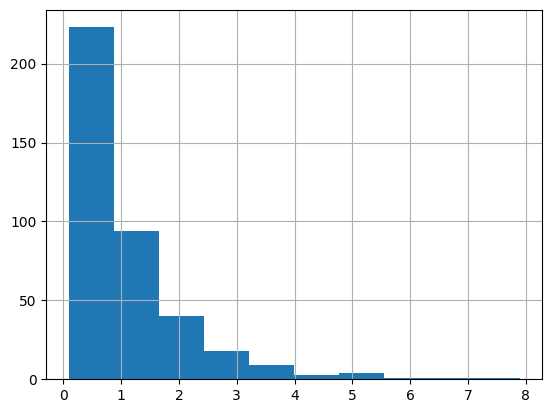

In [52]:
df['mean_views'].hist()

Анализ содержимого столбца "note" позволит извлечь ключевые слова или особенности, которые могут влиять на цену. используем TF-IDF, чтобы векторизовать текстовые данные и создать новые числовые признаки на основе них.

In [53]:
df['len_text'] = df['note'].apply(lambda x: len(x))

<Axes: >

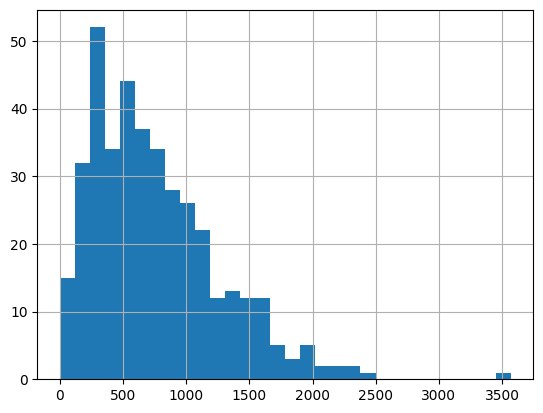

In [54]:
df['len_text'].hist(bins = 30)

In [55]:
df[df['len_text'] == 0]

,date_app,date_update,note,apartment_type,neighborhood,street,floor,total_area,living_area,kitchen_area,price,views,total_floors,age,living/total,kitchen/living,mean_views,len_text
33,2023-08-31,2023-08-31,,однокомнатная,,жукова,3,40.0,20.0,9.0,3050,8,9,3.814525,0.500000,2.222222,2.097247,0
83,2023-08-23,2023-08-23,,двухкомнатная,правобережный,им газеты правда,4,46.1,29.0,6.0,2600,27,5,11.814525,0.629067,4.833333,2.285323,0
108,2023-08-14,2023-08-14,,трехкомнатная,орджоникидзевский,труда,6,65.0,43.0,9.0,4980,27,9,20.814525,0.661538,4.777778,1.297171,0
195,2023-07-25,2023-08-07,,двухкомнатная,ленинский,набережная,2,60.0,35.0,9.0,4400,26,5,40.814525,0.583333,3.888889,0.637028,0


In [56]:
# определим модель spacy
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

In [57]:
# Складываем все тексты в один список
texts = df['note'].tolist()

In [58]:
# Лемматизация текста для текстов
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    try:
        res.append([token.lemma_ for token in doc])
    except:
        print(doc)

In [59]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(res, 3)]

['id:4851, ., \r\n, задаток, !, !, !, \r\n, в, продажа, двухкомнатный, квартира, в, центр, город, ., !, !, !, \r\n\r\n, наш, преимущество, перед, аналогичный, вариант, :, \r\n\r\n, жизнь, в, центр, город, ,, но, вдали, от, шум, дорога, ,, так, как, дом, находиться, в, квартал, ., развитой, инфраструктура, ,, в, шаговый, доступность, :, \r\n, •, супермаркет, ", монетка, ", ,, ", пятёрочка, ", и, множество, продуктовый, магазин, \r\n, •, тц, ", радуга, вкус, ", \r\n, •, детский, сад,  , 132-центр, развитие, ребёнок, ,, 112, ,, 117, ,, 122, \r\n, •, общеобразовательный, школа, ,, 63, ,, спортивный, школа, 3, \r\n, •, недалеко, развлекательный, комплекс, ", универсал, ", ,, магнитогорский, государственный, консерватория, им., м, ., и, ., глинки, ., \r\n, •, для, прогулка, и, активный, отдых, сквер, ", литературный, ", ,, сквер, ", консерваторский, ", \r\n\r\n, о, дом, \r\n, дом, панельный, ,, 5-ти, этажный, ., придомовый, территория, оборудовать, детский, площадка, и, парковочный, зона, .,

Удалим знаки препинания, цифры и слова, содержащие цифры. А также иностранные слова, которые не перевелись. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.

In [60]:
# определим регулярное выражение
word_pattern = re.compile("^[а-яё]*$")

In [61]:
# определим функцию для очистки текста
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [62]:
# очистим текст
corpus = list(map(remove_symbols, res))

In [63]:
# Определим как часто встречаются к корпусе пустые списки (удалены все слова)
corpus_empty = [li for li in corpus if len(li) < 1]
len(corpus_empty)

4

In [64]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
[", ".join(text) for text in random.SystemRandom().sample(corpus, 3)]

['продам, светлый, просторный, двухкомнатный, квартира, в, хороший, состояние, в, квартира, сделать, капитальный, ремонт, заменить, эл, проводка, выровнять, стена, установить, качественный, пластиковый, окно, натяжной, потолок, по, весь, квартира, хороший, м, к, дверь, сан, узел, совместить, в, кафель, пластиковый, труба, новый, водомер, хороший, входной, дверь, оставаться, кухонный, гарнитур, водогрейка, развитой, инфраструктура, в, шаговый, доступность, магазин, аптека, банкомат, школа, детский, сад, звоните, показать, в, удобный, для, вас, время, объект, в, наш, база',
 'задаток, продам, комнатный, квартира, вагончик, в, отличный, район, квартира, светлый, и, очень, тёплый, дом, расположен, в, двор, вдали, от, шум, и, пыль, дорога, квартира, под, ремонт, чистый, подъезд, хороший, сосед, в, шаговый, доступность, остановка, общественный, транспорт, сетевой, магазин, детский, сад, по, прописка, относиться, к, школа, квартира, без, долг, и, обременение, взрослый, собственник, чистый, пр

In [65]:
# Стоп-слова spacy
stopwords_spacy = model.Defaults.stop_words

print(len(stopwords_spacy))

768


Далее векторизируем полученный корпус.

In [66]:
# Посчитаем IDF всех наших слов, и отсечем слова с самым большим idf(очень редкие) и с самым маленьким
tfidf = TfidfVectorizer(stop_words=list(stopwords_spacy), min_df = 10, max_df = 0.9)

In [67]:
# Объединим списки слов в предложения
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['в продажа комнатный квартира с хороший ремонт окно выходить на два сторона останься кухонный гарнитура с техника стиральный машинка встроенные шкаф планировка очень удобный квартира отлично подойти для большой семья на выбор много детский сад и развивать центр школа школа искусство камертон торговый центр спортивный центр сквер большой выбор магазин кафе ресторан и многое другое очень удобный транспортный развязка рядом остановка общественный транспорт можно легко и быстро добраться в любой точка город один взрослый собственник квартира проверить обременение нет подходить под ипотека и мат капитал',
 'продаваться комнатный квартира нестандартный планировка в одном из хороший район город дом расположен так что из окно открываться прекрасный вид на город а главный все необходимый для комфортный проживание находиться в шаговый доступность большой выбор детский сад и развивать центр школа школа искусство камертон торговый центр спортивный центр сквер большой выбор магазин кафе ресторан и

In [68]:
# трансформируем корпус
x = tfidf.fit_transform(docs)

In [69]:
# проверим размерность
x.shape

(394, 426)

In [70]:
# Посмотрим на результат векторизации
x = pd.DataFrame(x.toarray(), columns = tfidf.get_feature_names_out())
pd.DataFrame(x)

,абзаково,агентство,адрес,аптека,база,балкон,банк,банный,безупречный,белый,...,экологически,эксклюзивный,электричество,электропроводка,электросчётчик,этаж,этажный,юг,южный,юридический
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.059800,0.0,0.049758,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
3,0.0,0.110076,0.0,0.066727,0.0,0.000000,0.000000,0.0,0.110076,0.0,...,0.111493,0.107442,0.0,0.000000,0.0,0.000000,0.098871,0.0,0.0,0.087666
4,0.0,0.000000,0.0,0.000000,0.0,0.140015,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,0.000000,0.0,0.116996,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.188385,0.0,0.167292,0.0,0.000000,0.000000,0.0,0.0,0.000000
390,0.0,0.000000,0.0,0.000000,0.0,0.085276,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
391,0.0,0.000000,0.0,0.000000,0.0,0.168220,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.192307,0.000000,0.0,0.0,0.000000
392,0.0,0.000000,0.0,0.106451,0.0,0.088575,0.180253,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.101259,0.000000,0.0,0.0,0.279712


Уменьшим признаковое пространство при помощи PCA, оставим 5 компонент. 

In [71]:
pca = PCA(n_components=5)
x = pca.fit_transform(x)
x

array([[ 0.03073232, -0.1639761 , -0.00761696,  0.02704625, -0.17552159],
       [-0.00242319, -0.16168202, -0.07954799, -0.13559357, -0.09090453],
       [ 0.00402194, -0.18979791, -0.12380783, -0.27113698, -0.05565641],
       ...,
       [-0.08501353,  0.11822557, -0.00837823,  0.00957668, -0.12372179],
       [ 0.16392008, -0.13321385,  0.11496365,  0.03194926, -0.04969328],
       [ 0.09167926,  0.00717903,  0.02176492, -0.09494116, -0.14537287]])

In [72]:
# Добавим новые признаки в исходный датафрейм
df = pd.concat([df.reset_index(drop = True), pd.DataFrame(x, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'])], axis = 1)
df.shape

(394, 23)

In [74]:
# Удалим столбец note и посмотрм на итоговый датасет
df = df.drop('note', axis = 1)
df.head()

,date_app,date_update,apartment_type,neighborhood,street,floor,total_area,living_area,kitchen_area,price,...,age,living/total,kitchen/living,mean_views,len_text,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,2023-08-30,2023-09-02,трехкомнатная,орджоникидзевский,труда,8,80.0,53.0,9.0,5999,...,4.814525,0.662500,5.888889,7.892783,690,0.030732,-0.163976,-0.007617,0.027046,-0.175522
1,2023-08-30,2023-09-02,четырехкомнатная,орджоникидзевский,труда,9,79.0,52.7,8.2,6350,...,4.814525,0.667089,6.426829,5.400325,1362,-0.002423,-0.161682,-0.079548,-0.135594,-0.090905
2,2023-09-02,2023-09-02,трехкомнатная,орджоникидзевский,ленина,6,105.0,78.0,14.0,8700,...,1.814525,0.742857,5.571429,2.755543,2018,0.004022,-0.189798,-0.123808,-0.271137,-0.055656
3,2023-09-02,2023-09-02,многокомнатная,,калмыкова,8,65.0,45.0,8.0,4800,...,1.814525,0.692308,5.625000,4.959977,1498,0.035497,-0.304469,-0.225116,0.219234,0.038571
4,2023-09-02,2023-09-02,двухкомнатная,,суворова,2,44.3,30.0,6.0,2980,...,1.814525,0.677201,5.000000,3.306651,377,-0.033308,0.034155,0.038934,-0.016740,-0.055891


## 2. Подготовка к обучению модели

### Разобьем данные на выборки

 - Разбиение датафрейма на выборки и анализ данных
 - Проверка мультиколлинеарности признаков и корреляции с таргетом.
 - Отбор признаков (Feature Selection)
 - Выбор моделей для обучения (2-3 модели).

In [75]:
# Разобьем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis = 1), 
                                        df['price'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [76]:
# Проверка правильности разбиения на выборки
len(df) == len(X_train) + len(X_test)

True

### Отбор признаков (Feature Selection)

In [78]:
numeric = X_train.select_dtypes(include=[np.number]).columns.to_list()

In [ ]:
selector.support_

### Проверка мультиколлинеарности признаков 

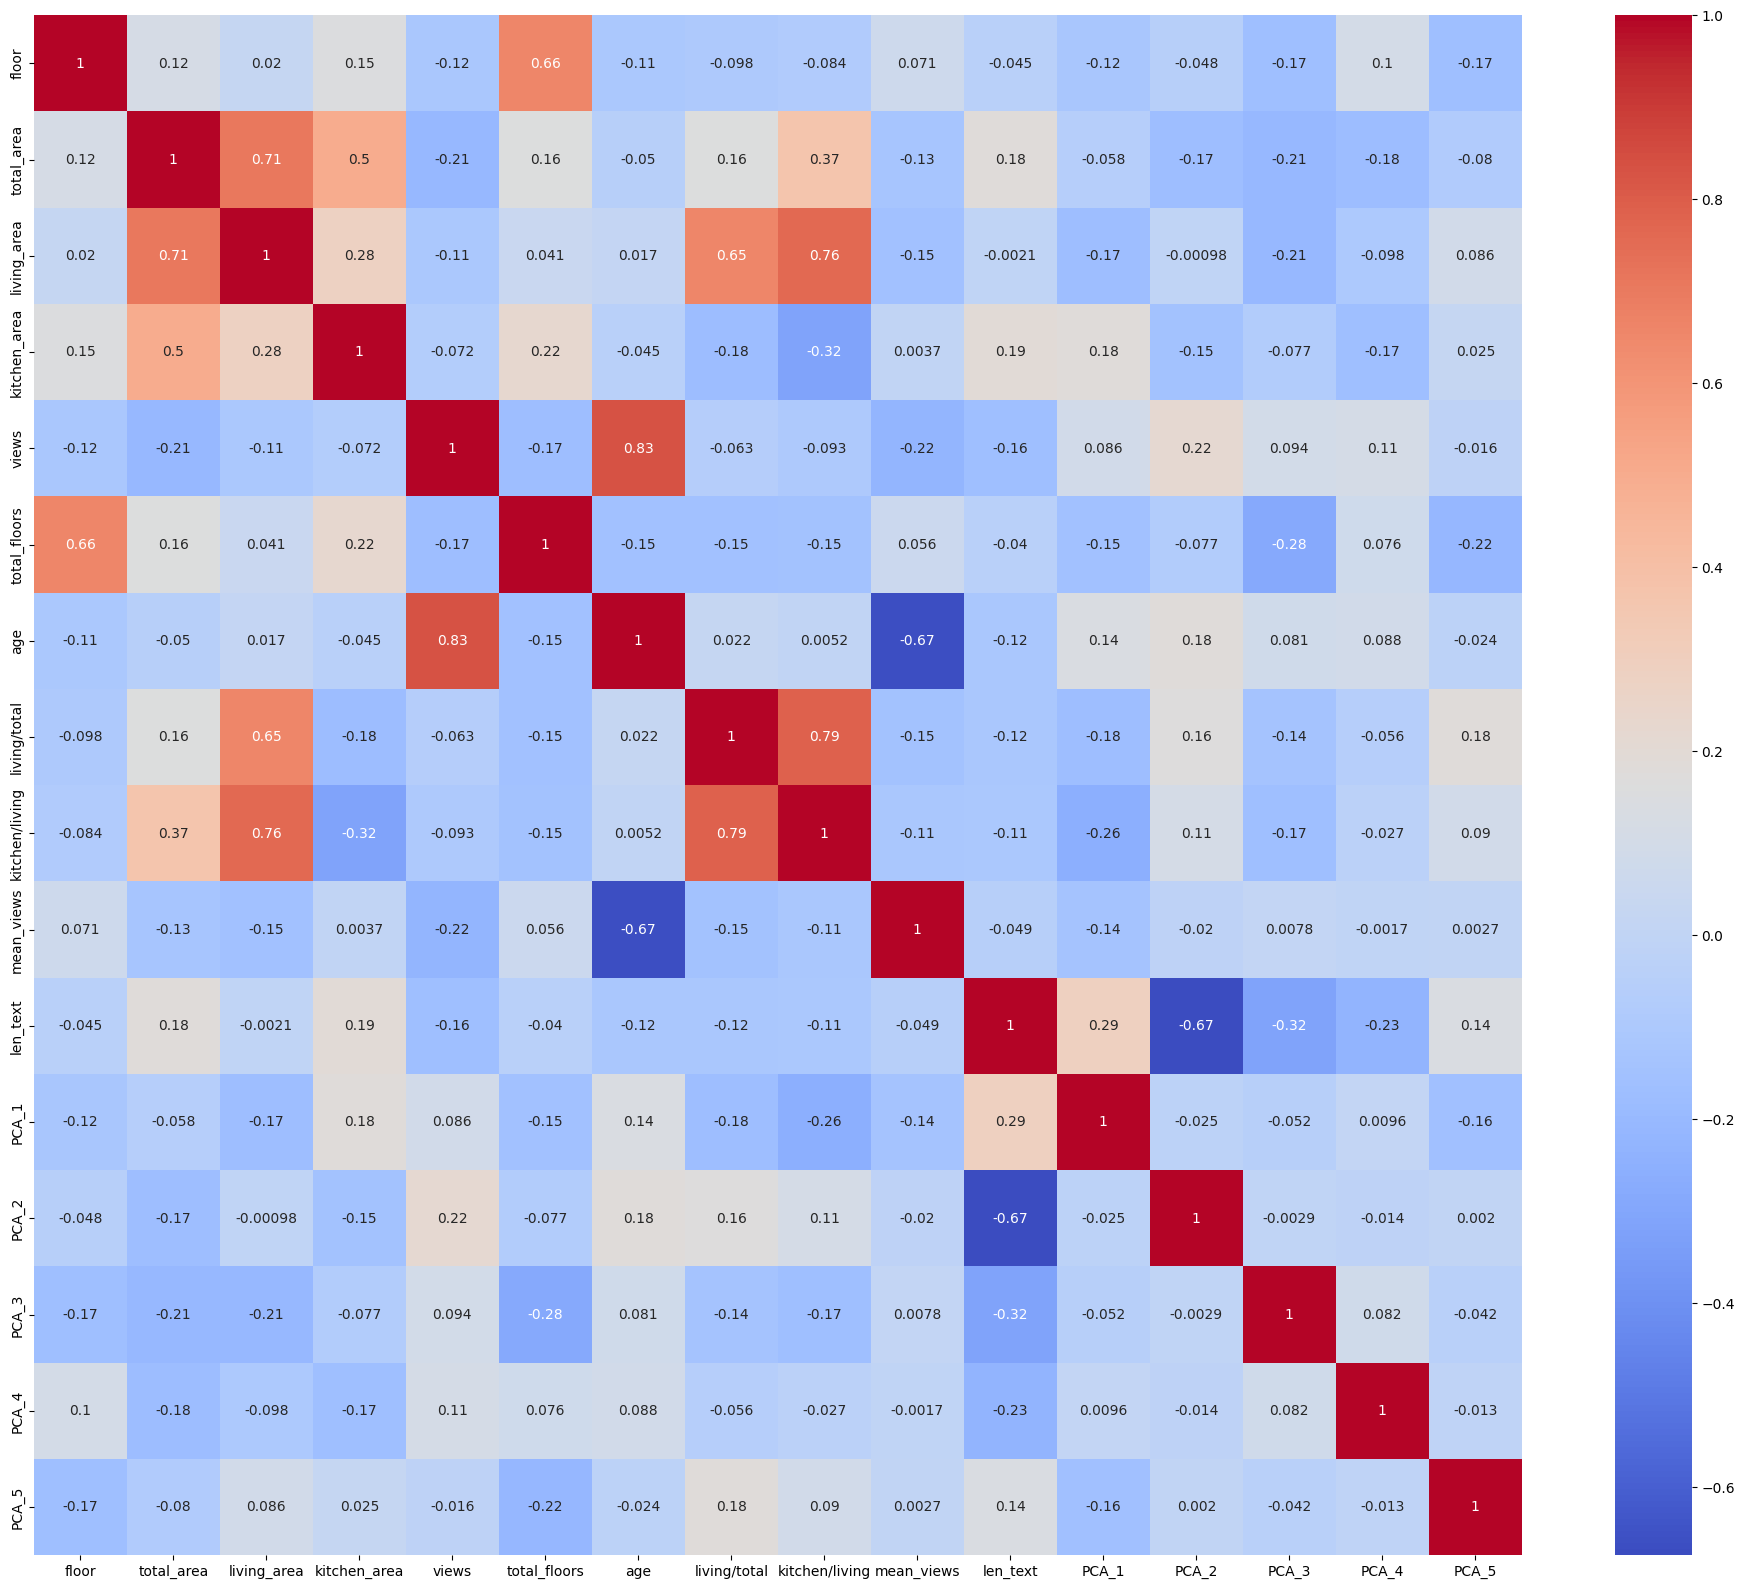

In [79]:
#Проверим есть ли корреляция между данными в разных столбцах
plt.figure(figsize=(24,20))
correlation_matrix = X_train[numeric].corr(method = 'spearman')
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm')
plt.show()

In [ ]:
#conn.close()